In [4]:
import os
import h5py
import numpy as np
from PIL import Image
import glob
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor


# Make an HDF5 files with training images #

### Why HDF5? 🤷‍♂️ ### 
HDF5 allows for transportability and scalability when running the training. Then entire file doesn't need to be read into memory at a one time. Also now images can be preprocesses (scaling needed for Xception)

### How is it Structured? ###
Images are loaded into a numpy array. Labels, filenames, and behavior (ie, dividing or not) are also encoded.

### How are data organized? ### 
Training data should be organized into subdirecties with the name of each subdirectory is the class label.

In [6]:
# Define image size and dataset paths
IMAGE_SIZE = (224, 224) # Size for Xception
DATASET_PATH = "/Volumes/patrick_ssd/CombinedTrainingData/"
H5_OUTPUT_PATH = "/Volumes/patrick_ssd/ifcb-training-2025.h5"
BATCH_SIZE = 5000  # Number of images to process before writing to disk

NUM_WORKERS = os.cpu_count()  # Use all available CPU cores for parallel image loading

# Create a dictionary to map species names to integer labels
species_classes = {}
species_class_counter = 0

# Count total images for progress bar
total_images = sum(
    len(files)
    for _, _, files in os.walk(DATASET_PATH)
    if any(file.lower().endswith((".png", ".jpg", ".jpeg")) for file in files)
)

# Function to load and preprocess a single image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize(IMAGE_SIZE)
    return np.array(image, dtype=np.uint8)

# Initialize storage lists for batch processing
image_batch, species_batch, behavior_batch, has_behavior_batch = [], [], [], []
num_samples = 0  # Track stored samples

# Open HDF5 file for writing with chunking
with h5py.File(H5_OUTPUT_PATH, "w") as h5_file:
    img_storage = h5_file.create_dataset(
        "images", shape=(0, *IMAGE_SIZE, 3), maxshape=(None, *IMAGE_SIZE, 3),
        dtype=np.uint8, chunks=(BATCH_SIZE, *IMAGE_SIZE, 3), compression="gzip"
    )
    species_storage = h5_file.create_dataset(
        "species_labels", shape=(0,), maxshape=(None,), dtype=np.int32, chunks=(BATCH_SIZE,)
    )
    behavior_storage = h5_file.create_dataset(
        "behavior_labels", shape=(0,), maxshape=(None,), dtype=np.int32, chunks=(BATCH_SIZE,)
    )
    has_behavior_storage = h5_file.create_dataset(
        "has_behavior_label", shape=(0,), maxshape=(None,), dtype=np.int32, chunks=(BATCH_SIZE,)
    )

    # Process dataset with batched writes and parallel image loading
    with tqdm(total=total_images, desc="Processing Images") as pbar:
        for species_class in sorted(os.listdir(DATASET_PATH)):
            species_class_path = os.path.join(DATASET_PATH, species_class)
            if not os.path.isdir(species_class_path):
                continue

            # Extract base species name and behavior flag
            base_species_name = species_class.replace("_dividing", "")
            is_dividing = "_dividing" in species_class

            # Assign numerical ID to species
            if base_species_name not in species_classes:
                species_classes[base_species_name] = species_class_counter
                species_class_counter += 1

            image_paths = [os.path.join(species_class_path, img) for img in os.listdir(species_class_path)
                           if img.lower().endswith((".png", ".jpg", ".jpeg"))]

            # Load images in parallel
            with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
                for image_array in executor.map(load_image, image_paths):
                    # Add to batch lists
                    image_batch.append(image_array)
                    species_batch.append(species_classes[base_species_name])
                    behavior_batch.append(1 if is_dividing else 0)
                    has_behavior_batch.append(1 if is_dividing else 0)

                    num_samples += 1
                    pbar.update(1)  # Update progress bar

                    # Write batch to HDF5 when it reaches the batch size
                    if len(image_batch) >= BATCH_SIZE:
                        img_storage.resize((img_storage.shape[0] + BATCH_SIZE, *IMAGE_SIZE, 3))
                        species_storage.resize((species_storage.shape[0] + BATCH_SIZE,))
                        behavior_storage.resize((behavior_storage.shape[0] + BATCH_SIZE,))
                        has_behavior_storage.resize((has_behavior_storage.shape[0] + BATCH_SIZE,))

                        img_storage[-BATCH_SIZE:] = np.array(image_batch, dtype=np.uint8)
                        species_storage[-BATCH_SIZE:] = np.array(species_batch, dtype=np.int32)
                        behavior_storage[-BATCH_SIZE:] = np.array(behavior_batch, dtype=np.int32)
                        has_behavior_storage[-BATCH_SIZE:] = np.array(has_behavior_batch, dtype=np.int32)

                        # Clear batch storage
                        image_batch, species_batch, behavior_batch, has_behavior_batch = [], [], [], []

        # Write remaining images (if any)
        if len(image_batch) > 0:
            batch_size = len(image_batch)
            img_storage.resize((img_storage.shape[0] + batch_size, *IMAGE_SIZE, 3))
            species_storage.resize((species_storage.shape[0] + batch_size,))
            behavior_storage.resize((behavior_storage.shape[0] + batch_size,))
            has_behavior_storage.resize((has_behavior_storage.shape[0] + batch_size,))

            img_storage[-batch_size:] = np.array(image_batch, dtype=np.uint8)
            species_storage[-batch_size:] = np.array(species_batch, dtype=np.int32)
            behavior_storage[-batch_size:] = np.array(behavior_batch, dtype=np.int32)
            has_behavior_storage[-batch_size:] = np.array(has_behavior_batch, dtype=np.int32)

    # Save species label mappings
    h5_file.attrs["species_classes"] = str(species_classes)

print(f"HDF5 dataset saved at {H5_OUTPUT_PATH}")

Processing Images: 100%|█████████▉| 1232970/1232977 [35:53<00:00, 572.51it/s] 

HDF5 dataset saved at /Volumes/patrick_ssd/ifcb-training-2025.h5



🔹 Available datasets in HDF5 file:
 - behavior_labels: shape (1232970,), dtype int32
 - has_behavior_label: shape (1232970,), dtype int32
 - images: shape (1232970, 224, 224, 3), dtype uint8
 - species_labels: shape (1232970,), dtype int32

🔹 Species Classes Mapping:
 - Akashiwo: 0
 - Alexandrium: 1
 - Amylax_Gonyaulax_Protoceratium: 2
 - Asterionellopsis: 3
 - Asterionellopsis_chain: 4
 - Asteromphalus: 5
 - Bad_Beads: 6
 - Bad_blurred: 7
 - Bad_mixed_phyto: 8
 - Bad_setae: 9
 - Boreadinium: 10
 - Centric: 11
 - Centric_fuzzy: 12
 - Ceratium_divaricatum: 13
 - Ceratium_furca: 14
 - Ceratium_fusus: 15
 - Ceratium_lineatum: 16
 - Chaetoceros: 17
 - Ciliate_cutoff: 18
 - Ciliate_large: 19
 - Ciliate_large_2: 20
 - Ciliate_other_morpho_1: 21
 - Clusterflagellate_morpho_1: 22
 - Clusterflagellate_morpho_2: 23
 - Corethron: 24
 - Coscinodiscus: 25
 - Cryptophyte: 26
 - Cylindrotheca_Nitzschia: 27
 - Detonula_Cerataulina_Lauderia: 28
 - Detritus: 29
 - Detritus_infection: 30
 - Dictyocha: 3

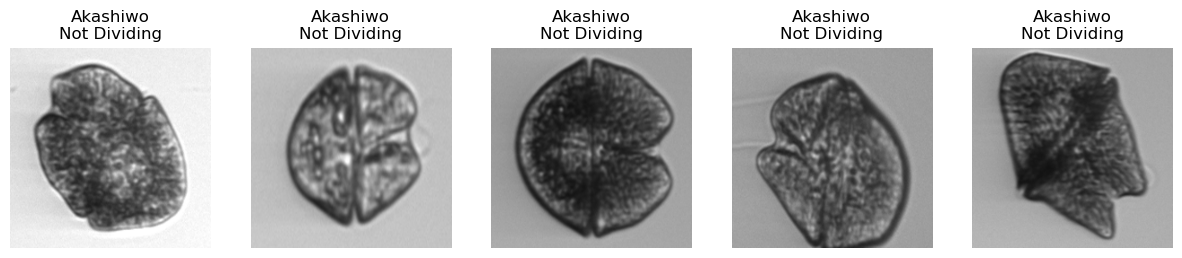

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Path to the HDF5 file
H5_PATH = "/Volumes/patrick_ssd/ifcb-training-2025.h5"


# Open the HDF5 file
with h5py.File(H5_PATH, "r") as h5_file:
    # Print dataset keys
    print("\n🔹 Available datasets in HDF5 file:")
    for key in h5_file.keys():
        print(f" - {key}: shape {h5_file[key].shape}, dtype {h5_file[key].dtype}")

    # Check species label mapping
    species_classes = eval(h5_file.attrs["species_classes"])
    print("\n🔹 Species Classes Mapping:")
    for species, label in species_classes.items():
        print(f" - {species}: {label}")

    # Load and print dataset shapes
    images = h5_file["images"]
    species_labels = h5_file["species_labels"]
    behavior_labels = h5_file["behavior_labels"]
    has_behavior_labels = h5_file["has_behavior_label"]

    print("\n✅ Data Summary:")
    print(f" - Total images: {images.shape[0]}")
    print(f" - Image size: {images.shape[1:]} (Height, Width, Channels)")
    print(f" - Species label count: {len(np.unique(species_labels))}")
    print(f" - Behavior label distribution: {np.unique(behavior_labels, return_counts=True)}")
    print(f" - Has behavior label distribution: {np.unique(has_behavior_labels, return_counts=True)}")

    # Show sample images with labels
    num_samples = 5  # Number of samples to display
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        image = images[i]
        species_label = species_labels[i]
        behavior_label = behavior_labels[i]

        axes[i].imshow(image)
        axes[i].axis("off")
        species_name = [key for key, val in species_classes.items() if val == species_label][0]
        behavior_text = "Dividing" if behavior_label == 1 else "Not Dividing"
        axes[i].set_title(f"{species_name}\n{behavior_text}")

    plt.show()